# Analyse zur Vorhersage von Kreditausfällen 

Einleitung: In der vorliegenden Analyse wird anhand der bestehenden Daten analysiert, welche Kundensegmente die höchste Kreditausfallwahrscheinlichkeit haben. Die Modellanalyse findet durch eine Random-Forest Modellierung und eine logistische Regression statt. Im Anschluss wird das ROC der beiden Modell untersucht, um festzustellen, ob die vorhandenen Daten für ein Modell der Kreditausfallwahrscheinlichkeit geeignet sind.

##### Inhaltsverzeichnis:
##### 1. Problemstellung
##### 2. Datenaufbereitung
##### 3. Explorative Datenanalyse
- Deskriptive Darstellung der Häufigkeit von Kreditausfällen
##### 4. Datenmodellierung
- Logistische Regression und Random-Forest-Modellierung
##### 5. Modellvalidierung
- ROC-Kurve
##### 6. Interpretation


## 1. Unternehmensfrage - Problemstellung

Ein Unternehmen möchte anhand eines bestehenden Datensatzes berechnen, welche Merkmale sich am besten zur Vorhersage eines Kreditsausfalls eignen. Die Unternehmensfrage lautet, ob durch die Daten ein Vorhersagemodel aufgestellt werden kann und welche Merkmale am besten zur Vorhersage geeignet sind bzw. welche Merkmale die höchste Wahrscheinlichkeit des Kreditausfalls haben. Die Analyse soll identifizieren, ob die Daten dazu in der Lage sind und welche Erkenntnisse aus den Daten gezogen werden können.

Fragestellung: Inwieweit können Kundensegmete für Kreditausfallwahrscheinlichkeit anhand der bestehenden Daten bestimmt werden?

------------------------------------------------------------------

## 2. Datenaufbereitung

In [1]:
import pandas as pd # damit die Daten geladen werden können
df = pd.read_csv("default of credit card clients.csv", sep=";") # Eine Sepperierung findet durch das Komma statt
df.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,Unnamed: 25
29995,29996,220000,1,3,1,39,0,0,0,0,...,31237,15980,8500,20000,5003,3047,5000,1000,0,NaN
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,5190,0,1837,3526,8998,129,0,0,0,NaN
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20582,19357,0,0,22000,4200,2000,3100,1,NaN
29998,29999,80000,1,3,1,41,1,-1,0,0,...,11855,48944,85900,3409,1178,1926,52964,1804,1,NaN
29999,30000,50000,1,2,1,46,0,0,0,0,...,32428,15313,2078,1800,1430,1000,1000,1000,1,NaN


In [148]:
## Von numerischen Variablen: Werte 0 werden NANs
import numpy as np
cols_to_decode = [
    col for col in df.columns
    if col.upper().startswith(("BILL", "PAY", "LIMIT"))
]
df[cols_to_decode] = df[cols_to_decode].replace(0, np.nan) ## Fehlende Werte werden entfernt

In [149]:
## Von kategorialen Variablen: Werte 0 werden dekodiert
df = df[df["MARRIAGE"] != 0].copy() ## Beziehungsstatus==0 hat keine Aussagekraft und wird entfernt
df = df[df["EDUCATION"] != 0].copy() ## Bildungsgrad==0 hat keine Aussagekraft und wird entfernt
df = df[df["AGE"] != 0].copy()

------------------------------------------------------------------

##### 2.1.1 Kreditausfälle

In [151]:
df["default payment next month"].value_counts() # 6636 Personen hatten über einen Zeitraum von 6 Erhebungen mindestens einen Kreditausfall

default payment next month
0    23301
1     6631
Name: count, dtype: int64

##### 1.2 Anzahl der verspäteten Zahlungen

In [152]:
pay_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]

verspaetung = df[pay_cols] > 0 # True = verspätet, False = pünktlich oder vorzeitig
verspaetung.head()

df["unterbrechungen"] = verspaetung.sum(axis=1)
df["unterbrechungen"].value_counts().sort_index() ## Wie oft kamen verspätete Zahlungen

unterbrechungen
0    19886
1     4414
2     1896
3     1153
4      949
5      298
6     1336
Name: count, dtype: int64

------------------------------------------------------------------

##### 2.2 Bildungsgrad & Beziehungsstatus

In [153]:
df["MARRIAGE"].value_counts() ## Wie oft gibt es welchen Beziehungsstatus

MARRIAGE
2    15954
1    13655
3      323
Name: count, dtype: int64

In [154]:
df["EDUCATION"].value_counts() ## Wie oft gibt es welche Bildungsgradkategorie

EDUCATION
2    14024
1    10581
3     4873
5      280
4      123
6       51
Name: count, dtype: int64

In [155]:
df["EDUCATION_CLEAN"] = df["EDUCATION"].replace({5:4, 6:4}) # Neue Variable Education_Clean wird erstellt; die Ausprägungen 5 und 6 werden auch zu 4 ("OTHERS") kodiert
df["EDUCATION_CLEAN"].value_counts() 

EDUCATION_CLEAN
2    14024
1    10581
3     4873
4      454
Name: count, dtype: int64

In [157]:
## One-Hot Codierung (Dummies) für die spätere Analyse
import pandas as pd
edu_dummies = pd.get_dummies(
    df["EDUCATION_CLEAN"],
    prefix="EDU",
    drop_first=True      # EDU_1 = Referenz
)
mar_dummies = pd.get_dummies(
    df["MARRIAGE"],
    prefix="MAR",
    drop_first=True      # MAR_1 = Referenz
)
df_dum = pd.concat([df, edu_dummies, mar_dummies], axis=1)

------------------------------------------------------------------

##### 2.3 Rechnungssaldo und Zahlungsbetrag

In [158]:
import pandas as pd

bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
pay_cols  = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

for b, p in zip(bill_cols, pay_cols):  
    df[f'PAY_RATIO_{b[-1]}'] = df[p] / df[b] ## Rechnungssaldo im Verhältnis zum Zahlbetrag wird berechnet

df['PAY_RATIO_MEAN'] = df[[f'PAY_RATIO_{i}' for i in range(1,7)]].mean(axis=1) ## Die durchschnittliche Pay_Ratio wird berechnet, um eine bessere Interpretation zu ermöglichen

df[['PAY_RATIO_1','PAY_RATIO_2','PAY_RATIO_3','PAY_RATIO_4','PAY_RATIO_5','PAY_RATIO_6','PAY_RATIO_MEAN']].head() # Übersichtliche Darstellung

,PAY_RATIO_1,PAY_RATIO_2,PAY_RATIO_3,PAY_RATIO_4,PAY_RATIO_5,PAY_RATIO_6,PAY_RATIO_MEAN
0,NaN,0.222115,NaN,NaN,NaN,NaN,0.222115
1,NaN,0.579710,0.372856,0.305623,NaN,0.613309,0.467875
2,0.051917,0.106937,0.073752,0.069779,0.066899,0.321564,0.115141
3,0.042562,0.041859,0.024345,0.038850,0.036914,0.033844,0.036396
4,0.232099,6.469312,0.279057,0.429799,0.035987,0.035492,1.246958


------------------------------------------------------------------

##### 2.4 Zahlungsbetrag im Verhältnis zu Kreditlimit

In [159]:
import pandas as pd

bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'] # Angenommen, df ist dein DataFrame und LIMIT_BAL, BILL_AMT1-6 existieren

for b in bill_cols:
    df[f'BILL_RATIO_{b[-1]}'] = df[b] / df['LIMIT_BAL'] # Berechnung der durchschnittlichen Bill Ratio für alle 6 Monate

df['BILL_RATIO_MEAN'] = df[[f'BILL_RATIO_{i}' for i in range(1,7)]].mean(axis=1) # Berechnung der durchschnittlichen Bill Ratio für alle 6 Monate

df[['BILL_RATIO_1','BILL_RATIO_2','BILL_RATIO_3','BILL_RATIO_4','BILL_RATIO_5','BILL_RATIO_6','BILL_RATIO_MEAN']].head() # Übersicht

,BILL_RATIO_1,BILL_RATIO_2,BILL_RATIO_3,BILL_RATIO_4,BILL_RATIO_5,BILL_RATIO_6,BILL_RATIO_MEAN
0,0.195650,0.155100,0.034450,NaN,NaN,NaN,0.128400
1,0.022350,0.014375,0.022350,0.027267,0.028792,0.027175,0.023718
2,0.324878,0.155856,0.150656,0.159233,0.166089,0.172767,0.188246
3,0.939800,0.964660,0.985820,0.566280,0.579180,0.590940,0.771113
4,0.172340,0.113400,0.716700,0.418800,0.382920,0.382620,0.364463


--------------------------------------------

##### 2.5 Alterskategorien
Es werden Alterskategorien erstellt, weil wir davon ausgehen, dass es keinen linearen Zusammenhang zwischen Kreditausfallwahrscheinlichkeit und Alter gibt. Aus diesem Grund haben die Alterskategorien eine stärkere Erklärungskraft für das spätere Modell.

In [168]:
bins = [34, 44, 54, 100]
labels = ["35-44", "45-54", "55+"]

df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, labels=labels)

age_dummies = pd.get_dummies(df["AGE_GROUP"], prefix="AGE")
df_dum = pd.concat([df, age_dummies], axis=1)

In [169]:
age_dummies = pd.get_dummies(
    df["AGE_GROUP"],
    prefix="AGE",
    dtype=int
)
df_dum = pd.concat([df, age_dummies], axis=1)

----------------------------------------------------------------------------------------

## 3. Explorative Datenanalyse

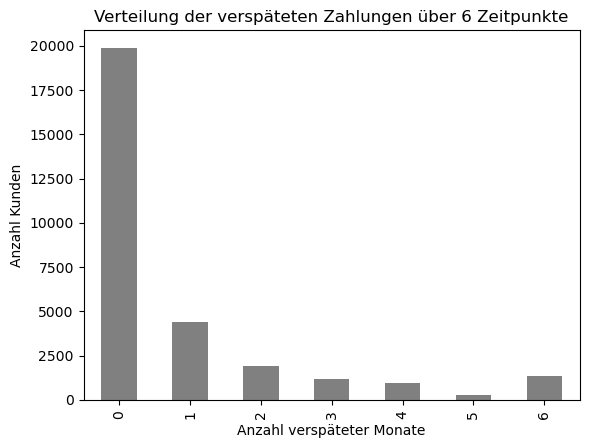

In [170]:
import matplotlib.pyplot as plt

df["unterbrechungen"].value_counts().sort_index().plot(kind="bar", color="grey")
plt.xlabel("Anzahl verspäteter Monate")
plt.ylabel("Anzahl Kunden")
plt.title("Verteilung der verspäteten Zahlungen über 6 Zeitpunkte")
plt.show()

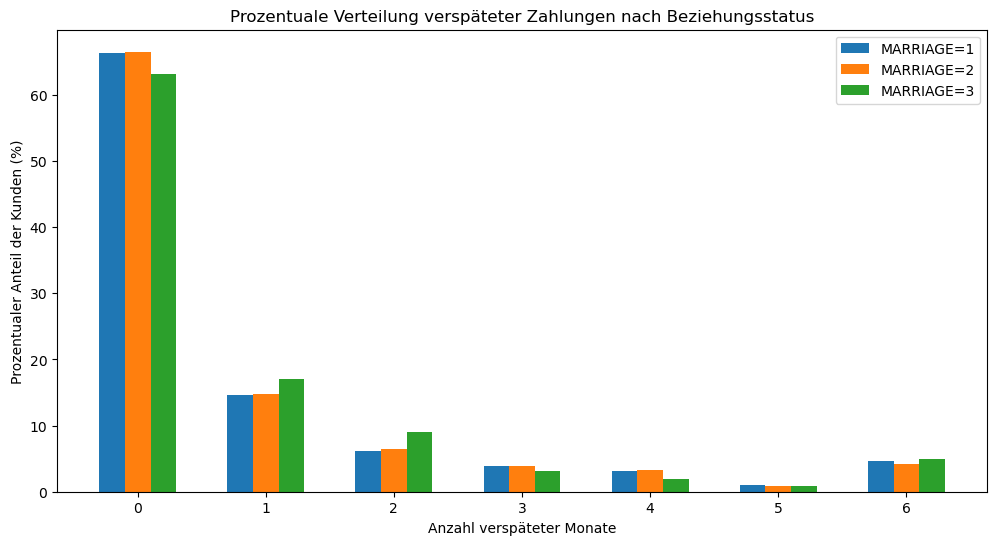

In [171]:
import matplotlib.pyplot as plt
import numpy as np

marriage_categories = sorted(df["MARRIAGE"].dropna().unique())
unterbrechungen_values = sorted(df["unterbrechungen"].dropna().unique())
x = np.arange(len(unterbrechungen_values))

plt.figure(figsize=(12,6))

for i, m in enumerate(marriage_categories):
    subset = df[df["MARRIAGE"] == m]["unterbrechungen"]
    counts = subset.value_counts().reindex(unterbrechungen_values, fill_value=0)
    percentages = counts / counts.sum() * 100  # Umrechnung in %
    plt.bar(x + i*bar_width, percentages, width=0.2, label=f'MARRIAGE={m}')

plt.xlabel("Anzahl verspäteter Monate")
plt.ylabel("Prozentualer Anteil der Kunden (%)")
plt.title("Prozentuale Verteilung verspäteter Zahlungen nach Beziehungsstatus")
plt.xticks(x + bar_width*(len(marriage_categories)-1)/2, unterbrechungen_values)
plt.legend()
plt.show()


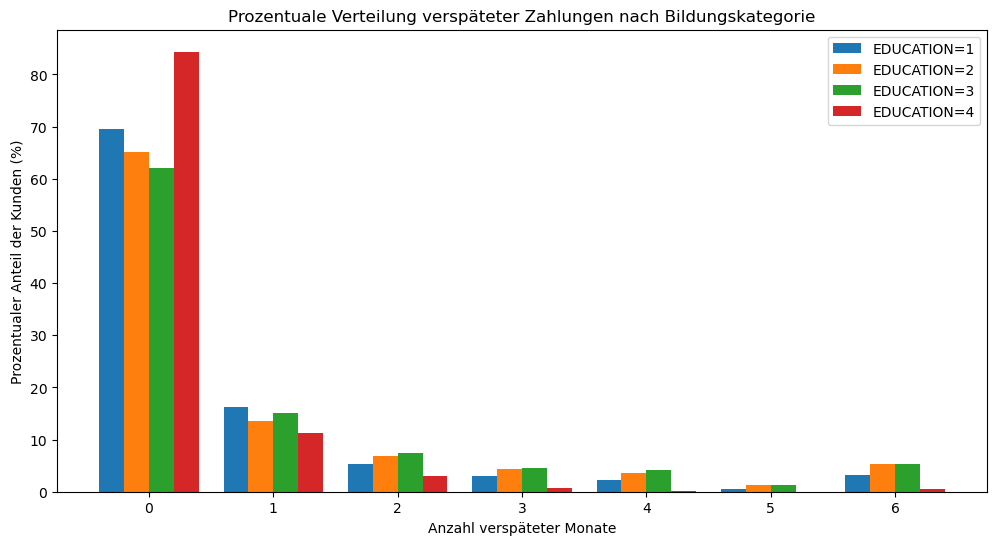

In [172]:
education_categories = sorted(df["EDUCATION_CLEAN"].dropna().unique())
x = np.arange(len(unterbrechungen_values))

plt.figure(figsize=(12,6))

for i, edu in enumerate(education_categories):
    subset = df[df["EDUCATION_CLEAN"] == edu]["unterbrechungen"]
    counts = subset.value_counts().reindex(unterbrechungen_values, fill_value=0)
    percentages = counts / counts.sum() * 100  # Umrechnung in %
    plt.bar(x + i*bar_width, percentages, width=0.2, label=f'EDUCATION={edu}')

plt.xlabel("Anzahl verspäteter Monate")
plt.ylabel("Prozentualer Anteil der Kunden (%)")
plt.title("Prozentuale Verteilung verspäteter Zahlungen nach Bildungskategorie")
plt.xticks(x + bar_width*(len(education_categories)-1)/2, unterbrechungen_values)
plt.legend()
plt.show()

Die Explorative Datenanalyse zeigt, dass Personen mit höherem Bildungsabschluss seltener keine verspätete Zahlung der Raten haben (die Variable Education=4 wurde mit "Others" kodiert und liefert keinen inhaltlichen Mehrwert). Gleichzeitig können wir sehen, dass besonders Personen, die nur einen "High School"-Abschluss haben, relativ häufiger verspätet ihre Zahlungen tätigen. Dies kann auf finanzielle Unterschiede zurückgeführt werden, die sich aus dem Schulabschluss ergeben. Aus dem Balkendiagramm des Beziehungsstatus können wir sehen, dass Personen, die verheiratet sind, seltener verspätete Zahlungen haben, als Personen, die verwitwet oder geschieden sind. Dies ergibt sich aus der Haushaltssituation der Personen, die einen Einfluss auf deren verspäteten Zahlungen hat. 

------------------------------------------------------------------

## 4. Datenmodellierung

Die logistische Regression dient der ökonomischen Interpretation der Einflussfaktoren, während der Random Forest aufgrund seiner höheren Prognosegüte insbesondere für das kreditrisikobasierte Kundenscoring geeignet ist. Die Modellgüte wurde mittels ROC-Kurve und AUC auf unabhängigen Testdaten verglichen.

##### 4.1 Logistische Regression für die Kreditausfallwahrscheinlichkeit

In [173]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Zielvariable (explizit numerisch)
y = pd.to_numeric(df["default payment next month"], errors="coerce")

edu_dummies = pd.get_dummies(
    df["EDUCATION_CLEAN"], prefix="EDU", drop_first=True
).astype(int)

mar_dummies = pd.get_dummies(
    df["MARRIAGE"], prefix="MAR", drop_first=True
).astype(int)

# Numerische Variablen
num_vars = df[[
    "BILL_RATIO_MEAN",
    "LIMIT_BAL",
    "PAY_RATIO_MEAN"
]].apply(pd.to_numeric, errors="coerce")

X = pd.concat([edu_dummies, mar_dummies, age_dummies, num_vars], axis=1) # Feature-Matrix

X = sm.add_constant(X) # Konstante

data = pd.concat([y, X], axis=1).dropna() # Gemeinsame NaN-Entfernung
y_clean = data[y.name]
X_clean = data.drop(columns=y.name)

logit_model = sm.Logit(y_clean, X_clean)
logit_result = logit_model.fit() # Logistische Regression

print(logit_result.summary()) # Regressionstabelle

Optimization terminated successfully.
         Current function value: 0.497070
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                27908
Model:                                  Logit   Df Residuals:                    27896
Method:                                   MLE   Df Model:                           11
Date:                        Thu, 29 Jan 2026   Pseudo R-squ.:                 0.04158
Time:                                16:27:51   Log-Likelihood:                -13872.
converged:                               True   LL-Null:                       -14474.
Covariance Type:                    nonrobust   LLR p-value:                2.732e-251
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9837      0.

            Logit Marginal Effects           
Dep. Variable:     default payment next month
Method:                                  dydx
At:                                   overall
                     dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
EDU_2              -0.0012      0.006     -0.214      0.830      -0.013       0.010
EDU_3              -0.0073      0.008     -0.956      0.339      -0.022       0.008
EDU_4              -0.2006      0.030     -6.637      0.000      -0.260      -0.141
MAR_2              -0.0357      0.006     -6.478      0.000      -0.047      -0.025
MAR_3              -0.0314      0.022     -1.431      0.152      -0.074       0.012
AGE_35-44           0.0099      0.006      1.634      0.102      -0.002       0.022
AGE_45-54           0.0156      0.008      2.023      0.043       0.000       0.031
AGE_55+             0.0144      0.013      1.084      0.278 

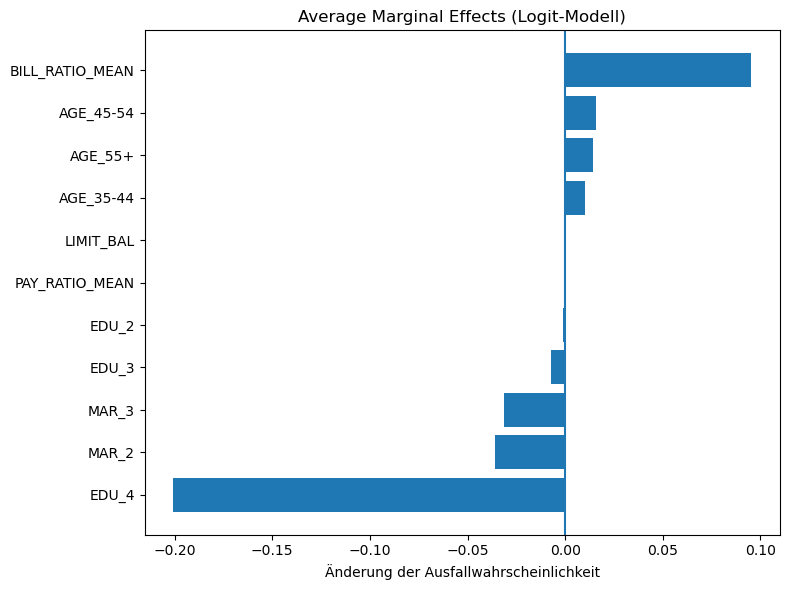

In [178]:
# Average Marginal Effects (AMEs)
marginal_effects = logit_result.get_margeff(at="overall")
print(marginal_effects.summary())

ame_df = marginal_effects.summary_frame() ## In Data Frame umwandeln
ame_df = ame_df.reset_index().rename(columns={"index": "Variable"})
ame_df

import matplotlib.pyplot as plt

# Sortieren nach Effektgröße
ame_df_sorted = ame_df.sort_values("dy/dx")

plt.figure(figsize=(8, 6))
plt.barh(
    ame_df_sorted["Variable"],
    ame_df_sorted["dy/dx"]
)
plt.axvline(0)
plt.title("Average Marginal Effects (Logit-Modell)")
plt.xlabel("Änderung der Ausfallwahrscheinlichkeit")
plt.tight_layout()
plt.show()

Personen die:
- single sind, haben eine signifikant geringere Ausfallwahrscheinlichkeit
- einen "high school" oder "university" Abschluss haben, haben eine statistisch bedeutend geringere Wahrscheinlichkeit als Personen mit einem "graduate school" Abschluss
- zwischen 45 und 54 Jahren alt sind, haben eine höhere Kreditausfallwahrscheinlichkeit

-----------------------------------------

##### 4.2 Random-Forest Modell

In [174]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, classification_report
from sklearn.model_selection import train_test_split

# 1. Feature-Matrix (identisch zum Logit)
X = X_clean.copy()   # aus dem Logit-Schritt (inkl. Dummies & numerisch)
y = y_clean.copy()

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Random Forest Modell
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# 3. Wahrscheinlichkeiten
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# 4. Optimaler Threshold (Youden-J)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f"Optimaler Threshold: {optimal_threshold:.3f}")

# 5. Klassifikation mit optimalem Threshold
y_pred_rf_opt = (y_proba_rf >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_rf_opt))


Optimaler Threshold: 0.493
              precision    recall  f1-score   support

           0       0.88      0.57      0.69      4390
           1       0.31      0.71      0.43      1192

    accuracy                           0.60      5582
   macro avg       0.59      0.64      0.56      5582
weighted avg       0.76      0.60      0.64      5582



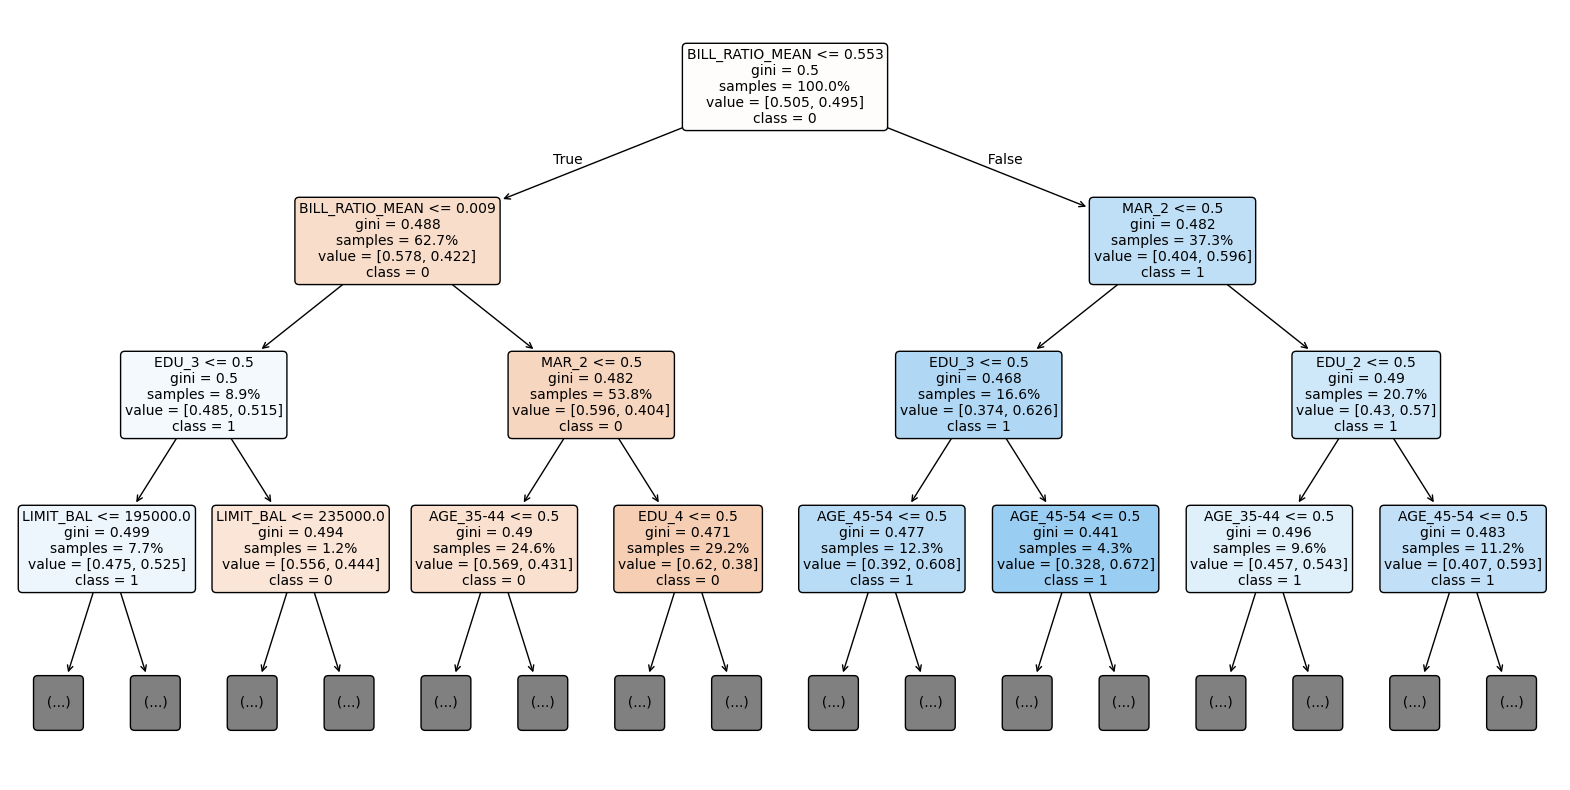

In [175]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. Einen Baum aus dem Random Forest auswählen, z.B. den ersten
tree = rf.estimators_[0]

# 2. Plotten
plt.figure(figsize=(20,10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=["0","1"],  # Labels deiner Zielvariablen
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    max_depth=3           # nur die ersten 3 Ebenen zeigen
)
plt.show()

- Kreditlimit-Auslastung ist der zentrale Risikotreiber
- Kreditnehmer mit hoher durchschnittlicher Auslastung ihres Kreditlimits haben die höchste prognostizierte Ausfallwahrscheinlichkeit.
- Familienstand, Bildungsniveau und Alter verändern das Ausfallrisiko deutlich innerhalb vergleichbarer finanzieller Situationen.
- Personen zwischen etwa 35 und 54 Jahren werden in mehreren Modellpfaden häufiger als ausfallgefährdet klassifiziert.
- Unabhängig von der Auslastung ist ein geringes Kreditlimit ein Indikator für erhöhte Ausfallwahrscheinlichkeit.
- Auch bei niedriger Auslastung treten Ausfälle auf, wenn weitere Risikofaktoren zusammenkommen - Bsp. Verheiratet oder geschieden 
- Die Kombination aus Kreditverhalten und demografischen Merkmalen ermöglicht eine transparente Segmentierung der Kreditnehmer.

-----------------------------------------

### 5. Modellevaluation

AUC: 0.645


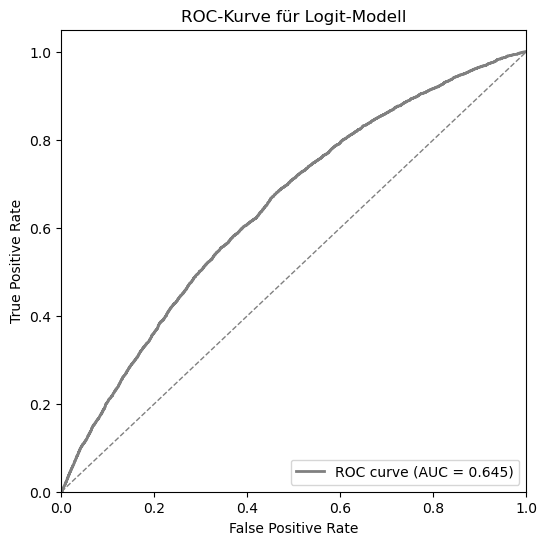

In [179]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Vorhersagewahrscheinlichkeiten für Klasse 1
y_proba = logit_result.predict(X_clean)

# ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_clean, y_proba)

# AUC
roc_auc = roc_auc_score(y_clean, y_proba)
print(f"AUC: {roc_auc:.3f}")

# ROC-Kurve plotten
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='grey', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve für Logit-Modell')
plt.legend(loc="lower right")
plt.show()


Random Forest AUC: 0.675


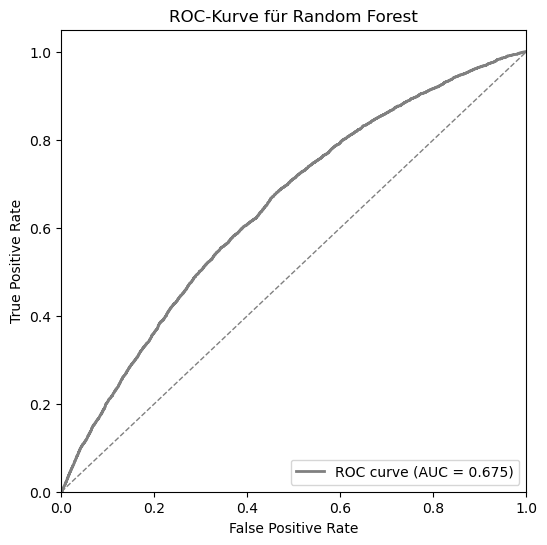

In [180]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# AUC berechnen
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest AUC: {roc_auc_rf:.3f}")

# ROC-Kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='grey', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve für Random Forest')
plt.legend(loc="lower right")
plt.show()

#### 6. Interpretation


In der Analyse zeigt sich, dass Personen im Alter von 45–55 Jahren eine höhere Kreditausfallwahrscheinlichkeit haben als unter 35-Jährige, während ledige Kund:innen ein geringeres Ausfallrisiko aufweisen. Die Bildungsvariable besitzt kaum Erklärungskraft, da sich die Kategorien nicht signifikant unterscheiden. Ein höheres Kreditlimit senkt die Ausfallwahrscheinlichkeit, während ein steigendes Bill-to-Pay-Ratio das Risiko erhöht. Diese Muster werden durch den Entscheidungsbaum grundsätzlich bestätigt, wobei Alter, Kreditlimit und Zahlungsbelastung die wichtigsten Trennkriterien sind.
Das logistische Regressionsmodell erreicht eine ROC-AUC von 0,65, das Random-Forest-Modell eine leicht bessere ROC-AUC von 0,67. Der Entscheidungsbaum weist insgesamt nur eine moderate Modellgüte auf, ist jedoch gut interpretierbar.